In [2]:
# The sys.stdout statements is to resolve proplems with printing statements in jupyter notebook, 
# when removed progress updates printed are not shown in the notebookr
import sys
import os
stdout = sys.stdout

from ms2query.ms2library import MS2Library
sys.stdout = stdout
from ms2query.utils import load_pickled_file
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

base_folder = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data"
tanimoto_scores_df_file = os.path.join(base_folder, "files_for_performance_analysis/ALL_GNPS_210409_positive_tanimoto_scores.pickle")
sqlite_file =  os.path.join(base_folder, "models_embeddings_files/ALL_GNPS_210409_train_split.sqlite")

# Load in results of selecting best matches for the test spectra
results = load_pickled_file(os.path.join(base_folder, 
                                         "files_for_performance_analysis/results_with_match_all_scores_test_spectra_dropout_reg_top_2000.pickle"))

# Test spectra
test_spectra = load_pickled_file(os.path.join(base_folder, "files_for_performance_analysis/ALL_GNPS_210409_test_split.pickle"))
# Only select first 2250 spectra belonging to 250 inchikeys not stored in library
test_spectra_without_match = test_spectra[:2250]
test_spectra_with_match = test_spectra[2250:]

In [3]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite

def select_best_match_by_ms2ds_and_calculate_tanimoto_score(
    result_matches, tanimoto_scores_file, query_spectra, sqlite_file_location, min_parent_mass = 10):
    """Returns a list with all the ms2query scores and tanimoto scores for the best matches"""
    
    tanimoto_scores = load_pickled_file(tanimoto_scores_file)
    ms2query_scores_and_tanimoto = []
    
    for query_spectrum in query_spectra:
        query_spectrum_id = query_spectrum.get("spectrumid")
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
        dataframe_with_scores = result_matches[query_spectrum_id]
        # Selection on highest MS2Deepscore
        large_enough_parent_mass = dataframe_with_scores.loc[dataframe_with_scores["mass_similarity"] > 0.8**min_parent_mass]
        if len(large_enough_parent_mass) > 0:
            best_match_spectrum_id = large_enough_parent_mass["ms2ds_score"].idxmax()
            best_match_score = large_enough_parent_mass["ms2ds_score"].max()

            best_match_inchikey = get_metadata_from_sqlite(
                sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
            tanimoto_score = tanimoto_scores.loc[best_match_inchikey, query_spectrum_inchikey]

            ms2query_scores_and_tanimoto.append((best_match_score, tanimoto_score))
    return ms2query_scores_and_tanimoto

def select_best_ms2query_and_calculate_tanimoto_score(
    result_matches, tanimoto_scores_file, query_spectra, sqlite_file_location):
    """Returns a list with all the ms2query scores and tanimoto scores for the best matches"""
    
    tanimoto_scores = load_pickled_file(tanimoto_scores_file)
    ms2query_scores_and_tanimoto = []
    
    for query_spectrum in query_spectra:
        query_spectrum_id = query_spectrum.get("spectrumid")
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
        
        best_match = result_matches[query_spectrum_id].iloc[0]
        best_match_score = best_match.loc["ms2query_model_prediction"]
        best_match_spectrum_id = best_match.name
    
        best_match_inchikey = get_metadata_from_sqlite(
            sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
        tanimoto_score = tanimoto_scores.loc[best_match_inchikey, query_spectrum_inchikey]
        
        ms2query_scores_and_tanimoto.append((best_match_score, tanimoto_score))
    return ms2query_scores_and_tanimoto

In [4]:
best_ms2ds_hits = select_best_match_by_ms2ds_and_calculate_tanimoto_score(results, tanimoto_scores_df_file, test_spectra_without_match, sqlite_file)
best_ms2q_hits = select_best_ms2query_and_calculate_tanimoto_score(results, tanimoto_scores_df_file, test_spectra_without_match, sqlite_file)


In [8]:
print(len(best_ms2ds_hits))
print(len(best_ms2q_hits))

2222
2250
hello


In [25]:
best_ms2q_hits_perfect_matches = select_best_ms2query_and_calculate_tanimoto_score(results, tanimoto_scores_df_file, test_spectra_with_match, sqlite_file)

KeyError: 'CCMSLIB00005960173'

In [21]:
from matplotlib import pyplot as plt
import numpy as np
        

def plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_scores_and_tanimoto, cut_offs, legend_title):
    bins = np.linspace(0, 1, 11)

    weight_to_convert_to_percentage = 100/len(ms2query_scores_and_tanimoto)

    for cut_off in cut_offs:
        selected_scores = [scores[1] for scores in ms2query_scores_and_tanimoto if scores[0] > cut_off]
        print("percentage selected = " + str(len(selected_scores)/len(ms2query_scores_and_tanimoto)*100))
        weights = [weight_to_convert_to_percentage] * len(selected_scores)
        
        plt.hist(selected_scores, bins, label = f"{cut_off:.2f}", weights = weights, histtype = "step")
    
    plt.legend(loc = "upper center", title = legend_title, ncol = 3)
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 25)

    plt.show

def compare_tanimoto_score_distribution(ms2query_scores_and_tanimoto, ms2deepscore_scores_and_tanimoto, cut_off_ms2q, cut_off_ms2d):
    bins = np.linspace(0, 1, 11)

    
    # Select scores for ms2query
    selected_scores_ms2q = [scores[1] for scores in ms2query_scores_and_tanimoto if scores[0] > cut_off_ms2q]
    ms2q_percentage_selected = len(selected_scores_ms2q)/len(ms2query_scores_and_tanimoto)*100
    print(ms2q_percentage_selected)
    weight_to_convert_to_percentage = 100/len(ms2query_scores_and_tanimoto)
    weights_ms2q = [weight_to_convert_to_percentage] * len(selected_scores_ms2q)

    # Select scores for ms2ds
    selected_scores_ms2d = [scores[1] for scores in ms2deepscore_scores_and_tanimoto if scores[0] > cut_off_ms2d]
    ms2d_percentage_selected = len(selected_scores_ms2d)/len(ms2deepscore_scores_and_tanimoto)*100
    print(ms2d_percentage_selected)
    weight_to_convert_to_percentage = 100/len(ms2deepscore_scores_and_tanimoto)
    weights_ms2d = [weight_to_convert_to_percentage] * len(selected_scores_ms2d)
    
    
    plt.hist([selected_scores_ms2d, selected_scores_ms2q], bins, label = ["MS2Deepscore", "MS2Query"], weights = [weights_ms2d, weights_ms2q])
    
    plt.legend(loc = "upper center", title = "Select on:")
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 15)

    plt.show

44.17777777777778
19.98199819981998


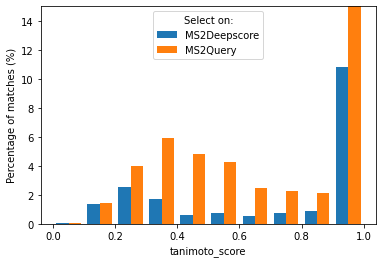

In [22]:
compare_tanimoto_score_distribution(best_ms2q_hits, best_ms2ds_hits, 0.696, 0.958)